In [153]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, cartopy, pandas as pd, numpy as np, regionmask, re
xr.set_options(keep_attrs = True)

matplotlib.rcParams['savefig.bbox'] = "tight"

from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

from geopy.geocoders import Nominatim

from IPython.display import clear_output

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

mapproj = cartopy.crs.PlateCarree()


def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
        

In [ ]:
def main_polygon(gdf):
    gdf = gdf.dissolve().explode(index_parts = False)
    gdf = gdf.loc[gdf.geometry.area == gdf.geometry.area.max()]
    return gdf


# quick method for area-weighted averaging (will add to WWA main but need to generalise dims first)
def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])

    
def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts


def wrap_lon(ds):
    
    # method to wrap longitude from (0,360) to (-180,180)
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

# Map of impacts

Cyclone Harry
- Southern Italy, esp Sicily, Sardinia, Calabria: damage to railways, port infrastructure, homes, businesses; disruption to transport; school and public buildings closures

Storm Kristin
- Portugal, esp Centro region and Lisbon metro area: damage to buildings, airplanes, schurches, schools, factories, power outages
- Spain, esp Andalusia region: Power outages affecting 150k buildings

Storm Leonardo
- Spain, esp Cadiz, Andalusia, Malaga: two fatalities, port disruption and closures, school closures
- Gibraltar: Port closures
- Morocco, esp Larache province: four fatalities
- Portugal, esp in Alentejo region: one fatality

Storm Marta
- Portugal, esp Algarve region, Atlantic coast: inundation and erosion, harbor and beach closures, rail suspensions, “catastrophic” crop damage
- Spain, esp Andalusia region, Avila province, Extremadura region: “catastrophic” crop damage, evacuations of tens of thousands, over 100 road closures, beach closures
- Morocco, esp Tangier, Sale, Casablanca: homes destroyed, four deaths

Storm Nils
- Italy, esp Sardinia, Lazio, Calabria: traffic disruption
- France, esp Nouvelle-Aquitaine, Occitaine: two fatalities, power outages for nearly 900k buildings, transport disruptions, school closures, ski resort closures
- Spain, esp Catalonia region, Galicia, Basque Country, Cantabria: one fatality, flight, rail and road suspensions and cancellations, school closures, sports suspensions, injuries

Storm Oriane
- Portugal: evacuations, transport disruptions
- Spain, esp Basque, Cadiz, Catalonia, Balearic islands, Madrid, Murcia: injuries, infrastructural damage

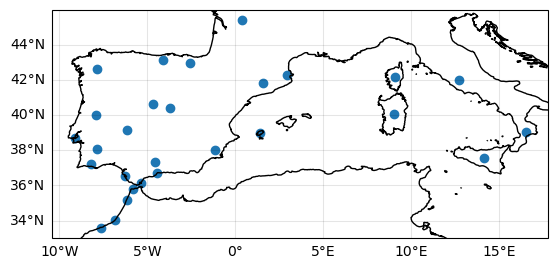

In [100]:
# map of locations mentioned
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

ax.scatter(px.lon, px.lat)
ax.coastlines()

ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

In [147]:
# list of storms
storms = {"Harry" : {"dates" : slice("2026-01-19", "2026-01-20"),
                     "sites" : ["Sardinia", "Sicily", "Calabria", "Corsica", "Emporda", "Valencia", "Barcelona",  "Sidi Bou Said"]},
          "Kristin" : {"dates" : slice("2026-01-27", "2026-01-29"),
                       "sites" : ["Centro, Portugal", "Lisbon", "Andalusia"]},
          "Leonardo" : {"dates" : slice("2026-02-04", "2026-02-04"),
                       "sites" : ["Cadiz, Spain", "Andalusia", "Malaga", "Gibraltar", "Larache", "Alentejo"]},
          "Marta" : {"dates" : slice("2026-02-07", "2026-02-07"),
                       "sites" : ["Algarve", "Avila", "Extremadura", "Tangier", "Sale, Morocco", "Casablanca", "Serranía de Ronda"]},
          "Nils" : {"dates" : slice("2026-02-12", "2026-02-12"),
                       "sites" : ["Landes", "Galicia", "Basque Country", "Cantabria", "Barcelona", "Tarn-et-Garonne"]},
          "Oriana" : {"dates" : slice("2026-02-13", "2026-02-13"),
                       "sites" : ["Basque Country", "Ibiza", "Cadiz, Spain", "Catalonia", "Madrid", "Murcia"]}
          }

# convert to dataframe
storm_df = pd.concat([pd.DataFrame([[storm, d, s] for d in pd.date_range(info["dates"].start, info["dates"].stop) for s in info["sites"]]) for storm, info in storms.items()])
storm_df.columns = ["storm", "date", "site"]
storm_df = storm_df.set_index("date")

In [148]:
# get list of points
px = pd.DataFrame({s : get_latlon(s) for s in list(set(storm_df.site))}).transpose()
px.to_csv("med-storms_reported-impacts.csv")

In [155]:
pr = xr.open_dataset("data/mswep_2026.nc").precipitation.sel(time = slice("2026-01-17", None))

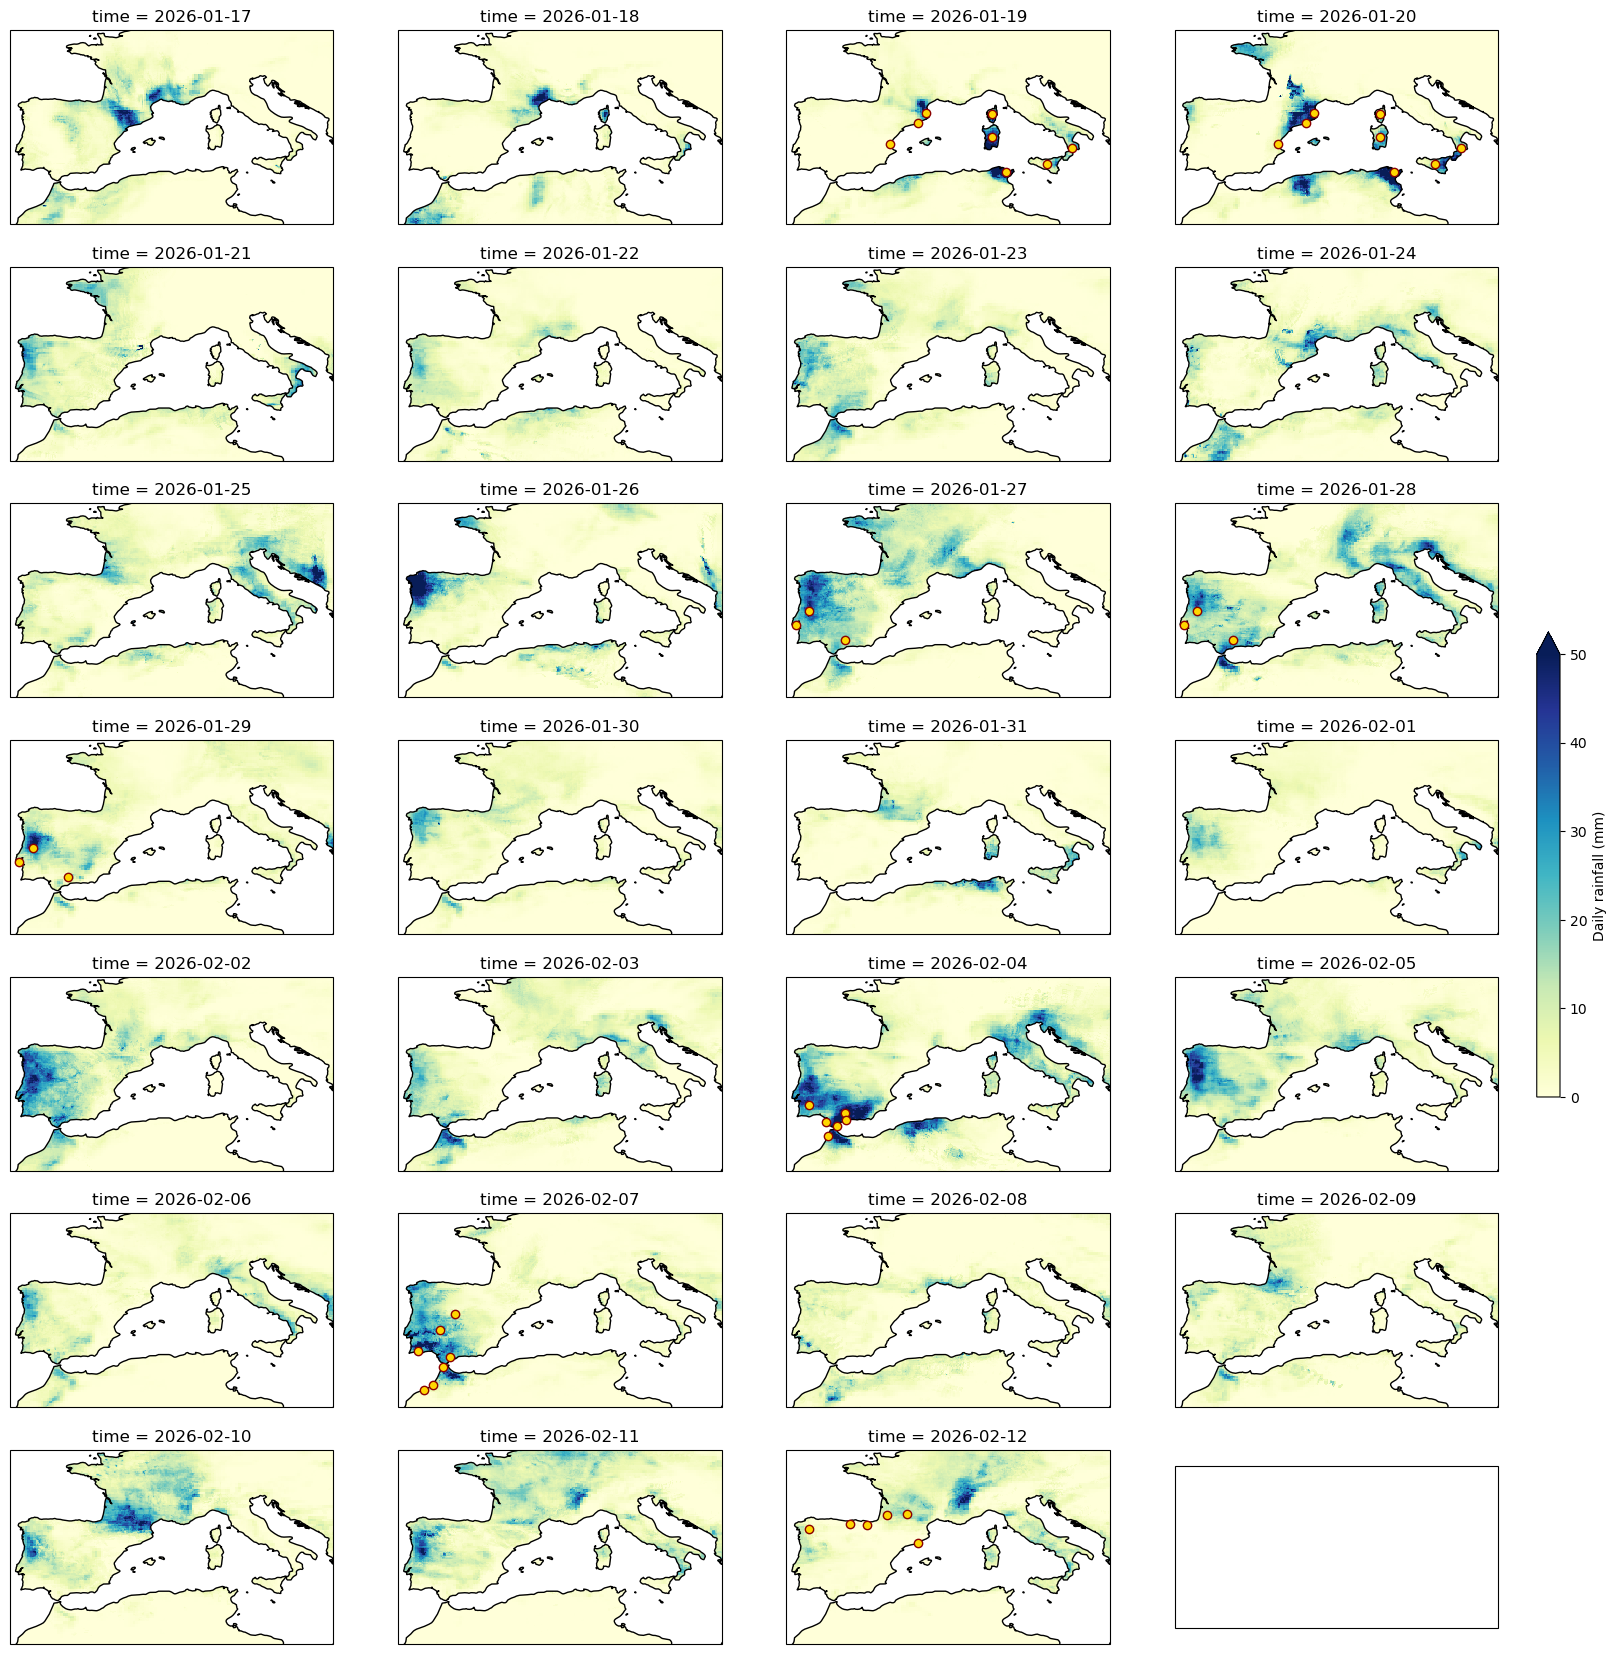

In [156]:
nc = 4; nr = int(np.ceil(len(pr.time)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj})

for i in range(len(pr.time)):
    ax = axs.flatten()[i]
    cbar = pr.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmax = 50, vmin = 0, add_colorbar = False)
    ax.coastlines()

    if pr.time.values[i] in storm_df.index:
        px_d = px.loc[storm_df.loc[pr.time.values[i], "site"]]
        ax.scatter(px_d.lon, px_d.lat, marker = "o", ec = "darkred", facecolor = "gold", zorder = 99)

plt.colorbar(cbar, ax = axs, fraction = 0.015, pad = 0.025, label = "Daily rainfall (mm)", extend = "max")

plt.savefig("fig/stampplots-daily_mswep.png")

# NAO

## Compare versions

In [215]:
nao_stn = pd.read_csv("data/nao-stn_monthly_ucar.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_stn"})
nao_pc = pd.read_csv("data/nao-pc_monthly_noaa.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_pc"})

nao = pd.merge(nao_stn, nao_pc, left_index = True, right_index = True)

In [216]:
nao.corr()

,nao_stn,nao_pc
nao_stn,1.000000,0.691579
nao_pc,0.691579,1.000000


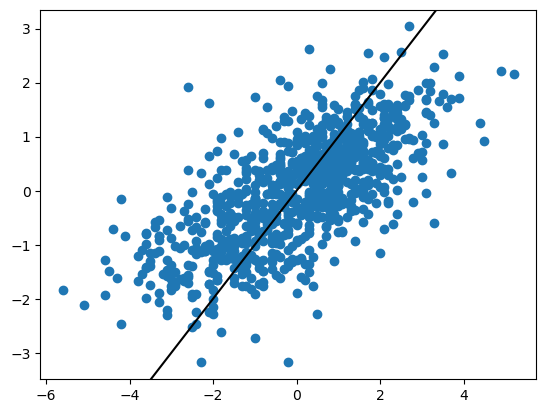

In [217]:
plt.scatter(nao.nao_stn, nao.nao_pc)
plt.axline((0,0), slope = 1, color = "k")

In [218]:
nao_era5 = pd.read_csv("data/nao-stn_monthly_era5.csv", index_col = 0, parse_dates = [0]).rename(columns = {"nao" : "nao_era5"})

In [219]:
nao = pd.merge(nao, nao_era5, left_index = True, right_index = True)

In [220]:
nao.corr()

,nao_stn,nao_pc,msl
nao_stn,1.000000,0.691579,0.861463
nao_pc,0.691579,1.000000,0.692959
msl,0.861463,0.692959,1.000000


In [221]:
nao_djf = nao.loc[nao.index.month.isin([1,2,12])].resample("YE-FEB").mean()
nao_djf.index = nao_djf.index.year

gmst = pd.read_csv("ts/gmst.dat", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year")

In [222]:
# station index is much less correlated with GMST
pd.merge(gmst, nao_djf, left_index = True, right_index = True).corr()

,gmst,nao_stn,nao_pc,msl
gmst,1.000000,0.282549,0.450690,0.289233
nao_stn,0.282549,1.000000,0.910448,0.985477
nao_pc,0.450690,0.910448,1.000000,0.914968
msl,0.289233,0.985477,0.914968,1.000000


In [223]:
gmst_coeffs = (nao_djf.to_xarray().assign_coords(index = gmst.loc[nao_djf.index].gmst)).polyfit("index", deg = 1)
gmst_fitted = xr.polyval(gmst.to_xarray().gmst, gmst_coeffs)

<Axes: >

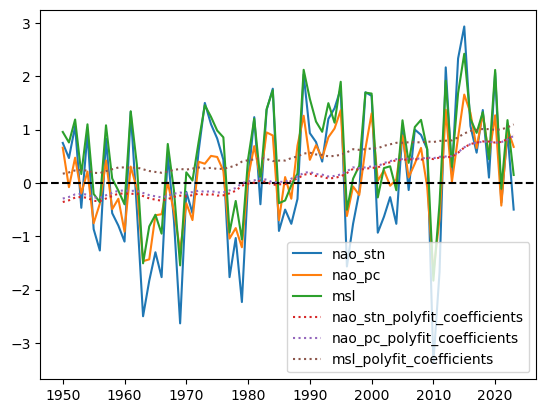

In [224]:
nao_djf.plot()
plt.axhline(0, color = "k", ls = "--")

gmst_fitted.to_dataframe().loc[nao_djf.index].plot(ax = plt.gca(), ls = ":")

In [225]:
#but actually we have a much longer time series from the station version, although it doesn't span to 2026
naos_djf = nao_stn.loc[nao_stn.index.month.isin([1,2,12])].resample("YE-FEB").mean()
naos_djf.index = naos_djf.index.year

gmst_coeffs2 = (naos_djf.loc[slice("1879",None)].to_xarray().assign_coords(index = gmst.loc[slice(None, 2023)].gmst)).polyfit("index", deg = 1)
gmst_fitted2 = xr.polyval(gmst.loc[slice(None, 2023)].to_xarray().gmst, gmst_coeffs2)

pd.merge(gmst, naos_djf, left_index = True, right_index = True).corr()

,gmst,nao_stn
gmst,1.000000,0.116123
nao_stn,0.116123,1.000000


<Axes: xlabel='year'>

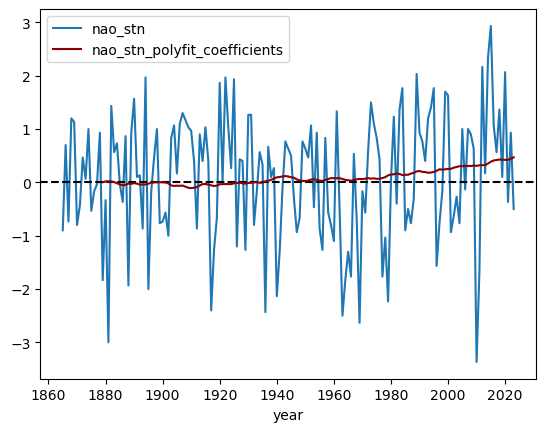

In [226]:
naos_djf.plot()
plt.axhline(0, color = "k", ls = "--")

gmst_fitted2.to_dataframe().plot(ax = plt.gca(), color = "darkred")

# Quick look at time series


In [74]:
# ! wget https://climexp.knmi.nl/dyn_links/era5_tp_daily_eu_extended_Portugal_0-40.00E_30.00-75.00N_firstyear-lastyear_su.nc -O data/era5_tp_daily_Portugal.nc
! wget https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat -O ts/gmst.dat


--2026-02-12 16:23:17--  https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
connected. to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 4762 (4.7K)
Saving to: ‘ts/gmst.dat’

ts/gmst.dat         100%[===================>]   4.65K  --.-KB/s    in 0s      

2026-02-12 16:23:19 (40.9 MB/s) - ‘ts/gmst.dat’ saved [4762/4762]



## MSWEP

MSWX only has data until Feb 5th while MSWEP has to 10th

In [2]:
da = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswep/2026/*.nc").sel(lon = slice(-10,-5), lat = slice(45,35)).precipitation.load()

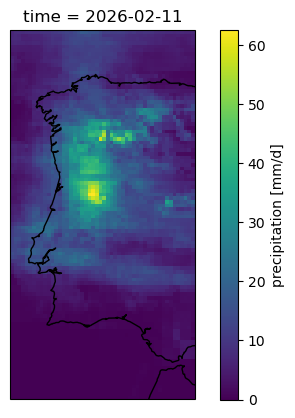

In [3]:
da.isel(time = -1).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

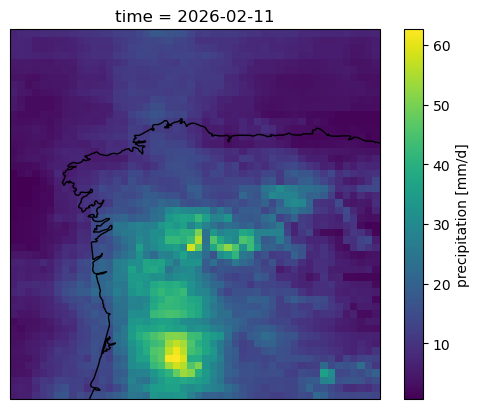

In [4]:
da.isel(time = -1).sel(lat = slice(None, 40)).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

In [113]:
rm = regionmask.mask_geopandas(main_polygon(regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["P"]]), da)

In [114]:
# extract time series & save
ts_portugal = da.where(rm == 0).mean(["lat", "lon"])
ts_nportugal = da.where(rm == 0).sel(lat = slice(None, 40)).mean(["lat", "lon"])

ts_portugal.to_netcdf("data/ts_pr_mswep_portugal.nc")
ts_nportugal.to_netcdf("data/ts_pr_mswep_nportugal.nc")

xr.merge([ts_portugal.rename("pr_pt"), ts_nportugal.rename("pr_npt")]).to_dataframe().to_csv("data/ts_pr_mswep_portugal.csv")

## ERA5

In [ ]:
da = xr.open_dataset("data/era5_tp_daily_Portugal.nc").tp.sel(lon = slice(-10,None), lat = slice(None, 37))

In [21]:
ts_portugal = da.mean(["lat", "lon"])
ts_nportugal = da.sel(lat = slice(None, "40")).mean(["lat", "lon"])

In [ ]:
ts_portugal.rename("pr_pt").to_netcdf("data/ts_pr_era5x_portugal.nc")
ts_nportugal.rename("pr_npt").to_netcdf("data/ts_pr_era5x_nportugal.nc")

In [17]:
xr.merge([ts_portugal.rename("pr_pt"), ts_nportugal.rename("pr_npt")]).to_dataframe().to_csv("data/ts_pr_era5x_portugal.csv")

In [50]:
da.isel(time = -1).plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [4]:
ts_portugal.sel(time = slice("2025",None)).plot()

NameError: name 'ts_portugal' is not defined

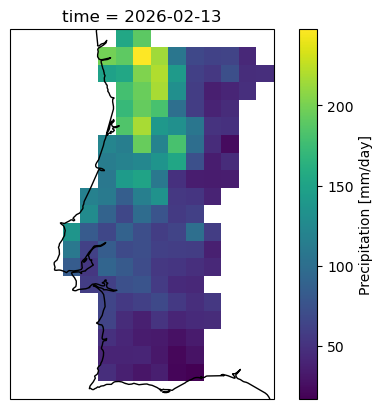

In [ ]:
da.isel(time = -1).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

## Compare time series

In [ ]:
ts_mswx = pd.read_csv("data/ts_pr_mswep_portugal.csv", index_col = "time", parse_dates = ["time"])
ts_era5 = pd.read_csv("data/ts_pr_era5x_portugal.csv", index_col = "time", parse_dates = ["time"])

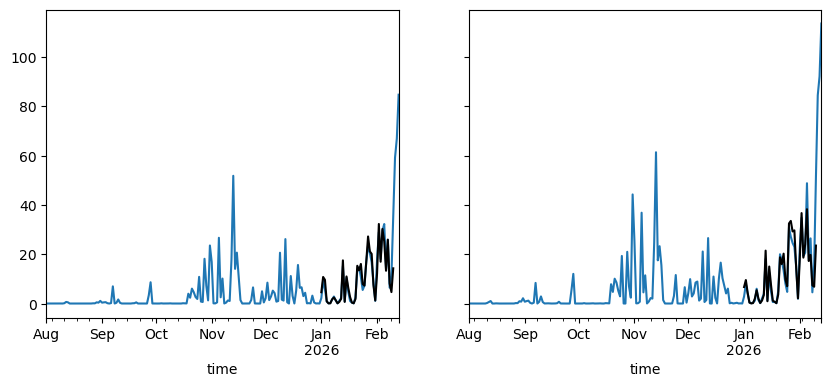

In [116]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharex = True, sharey = True)

for i in range(2):
    ax = axs[i]
    rnm = ["pt", "npt"][i]
    ts_era5.loc[slice("2025-08",None), "pr_"+rnm].plot(ax = ax)
    ts_mswx.loc[slice("2025-08",None), "pr_"+rnm].plot(ax = ax, color = "k")

## Timing of annual maximum

In [125]:
ts_era5 = pd.read_csv("data/ts_pr_era5x_portugal.csv", index_col = "time", parse_dates = ["time"]).to_xarray()

In [129]:
daymax = xr.concat([ts_era5.sel(time = str(y)).idxmax().expand_dims(year = [y]) for y in range(1950,2027)], "year")

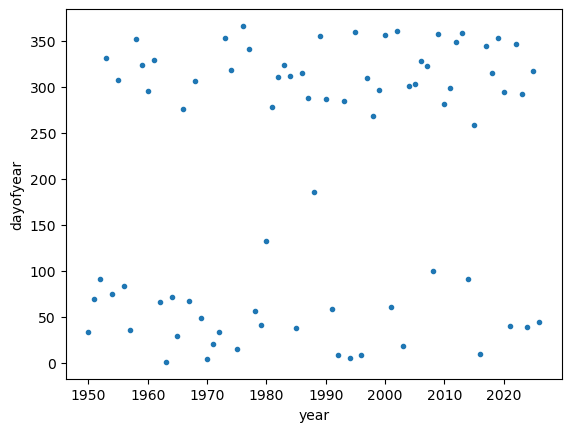

In [134]:
daymax.pr_pt.dt.dayofyear.plot(marker = ".", ls = "")

## Accumulations

In [ ]:
def y_offset(months): return datetime(2020,months,1).timetuple().tm_yday

In [37]:
rnm = "nportugal"
pr = eval("ts_"+rnm)

doy_offset = 0 #y_offset(5)
# pr.rolling(time = 91).sum().dropna("time").to_netcdf("pr-91day_"+rnm+"_era5land.nc")   # data for Tom
pr = pr.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in pr.time.values])) # shift time for offset axes

days = pd.date_range(start = "2024-01-01", end = "2025-01-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

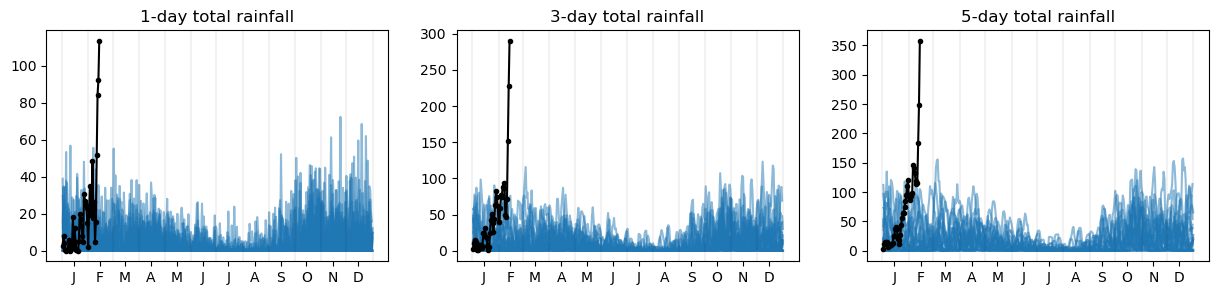

In [41]:
ndays = [1,3,5]

nc = 3; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = pr.rolling(time = nd).sum()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99, marker = ".")
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day total rainfall")

    # ylim = ax.get_ylim()
    # if rnm == "chile2026":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    # elif rnm == "patagonia":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    # ax.set_ylim(ylim)

# plt.savefig("fig/expl_accumulated-pr_"+rnm+"_.png")